In [1]:
from utils import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

### Anomaly Detection

Before we decide which type of network to be used, we need to first inspect the data, e.g. we want check if in the network_combined csv, each route exists only one type of transportation mode, or there are multiple modes for the same route.

In [3]:
all_cities = list_cities()

In [4]:
modes = ['combined', 'walk', 'bus']

for mode in modes:
    duplicate_cities = check_duplicate_route(all_cities, mode)
    if duplicate_cities:
        print(f"In network_{mode}, there are multiple transportation modes for the same route in:")
        for city in duplicate_cities:
            print(f"- {city}")
    else:
        print(f"In network_{mode}, all from_stop_I and to_stop_I are unique in all cities.")

In network_combined, there are multiple transportation modes for the same route in:
- paris
- melbourne
- luxembourg
- helsinki
- venice
- prague
- berlin
- rome
In network_walk, all from_stop_I and to_stop_I are unique in all cities.
In network_bus, all from_stop_I and to_stop_I are unique in all cities.


Based on the above examination, it is better to use `nx.MultiDiGraph`

Plot a single city's route percentages

In [5]:
Gs_combined = [load_graph(city, "combined") for city in all_cities]

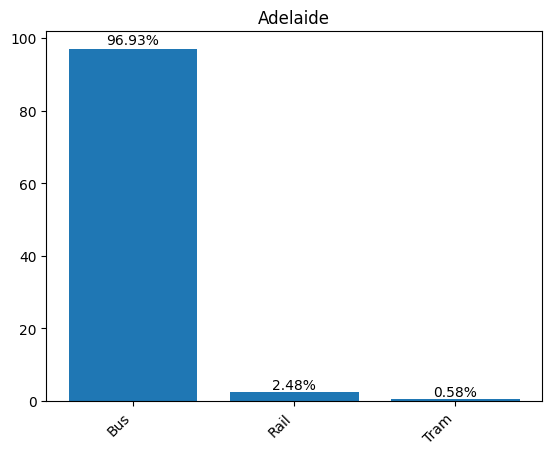

In [6]:
plot_route_percentages('adelaide')

Plot all cities' route percentages in a single plot

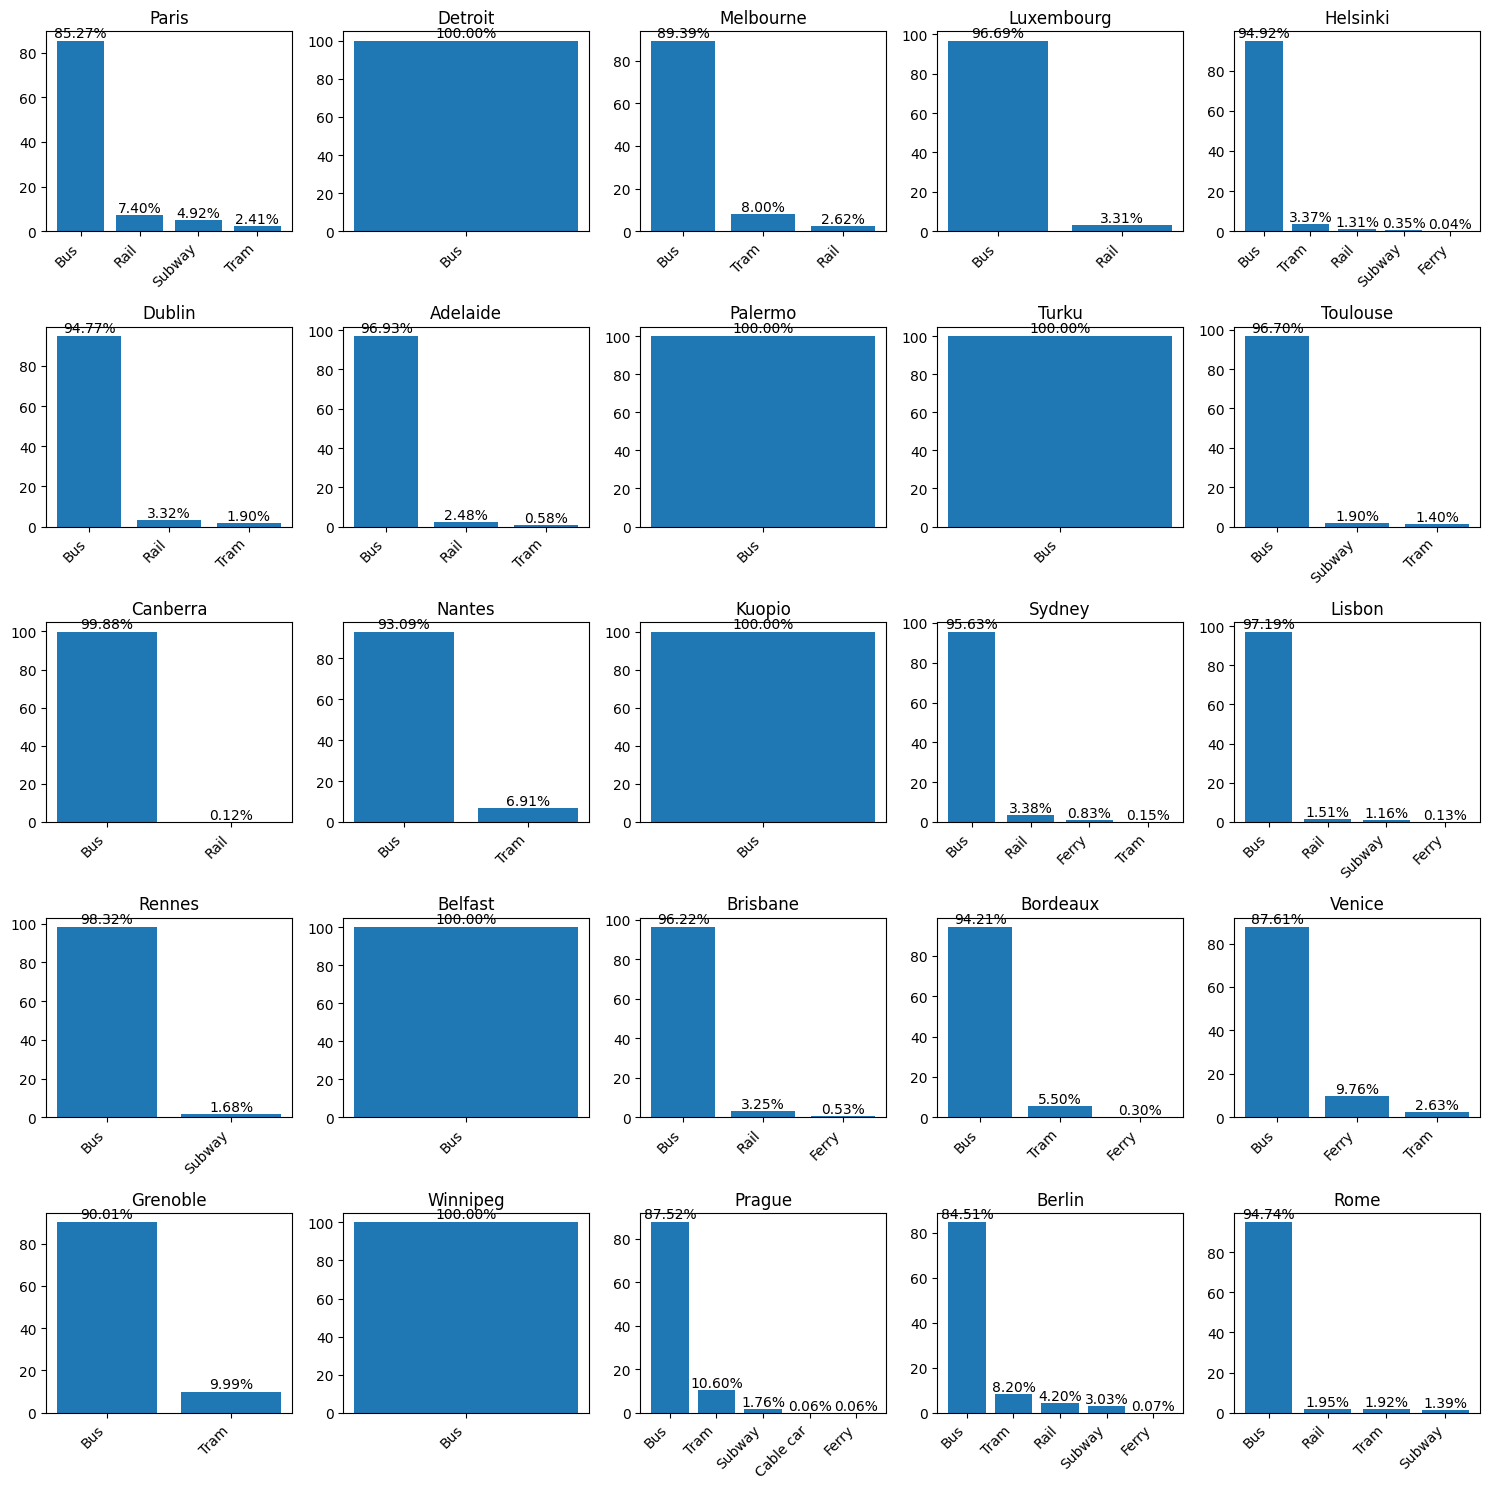

In [7]:
# Get the list of cities
cities = list_cities()

# Create a 5x5 subplot grid
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Plot route percentages for each city
for ax, city, graph in zip(axs.flatten(), cities, Gs_combined):
    plot_route_percentages(city, graph, ax)

plt.tight_layout()
plt.show()


Plot a single city's degree distribution

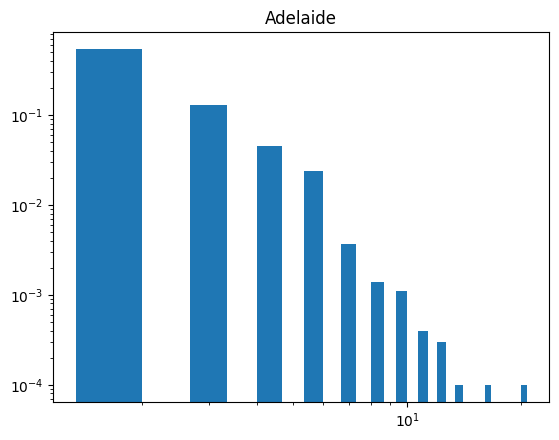

In [8]:
plot_degree_distribution('adelaide')

Plot all cities' degree distributions in a single plot

In [9]:
max_degrees = [max(g.degree(), key=lambda x: x[1])[1] for g in Gs_combined]
print("Max degree:", max(max_degrees))


Max degree: 36


Power law distribution, typical of real-world networks, gamma determines the slope, is correct, but the C param varies per network mode

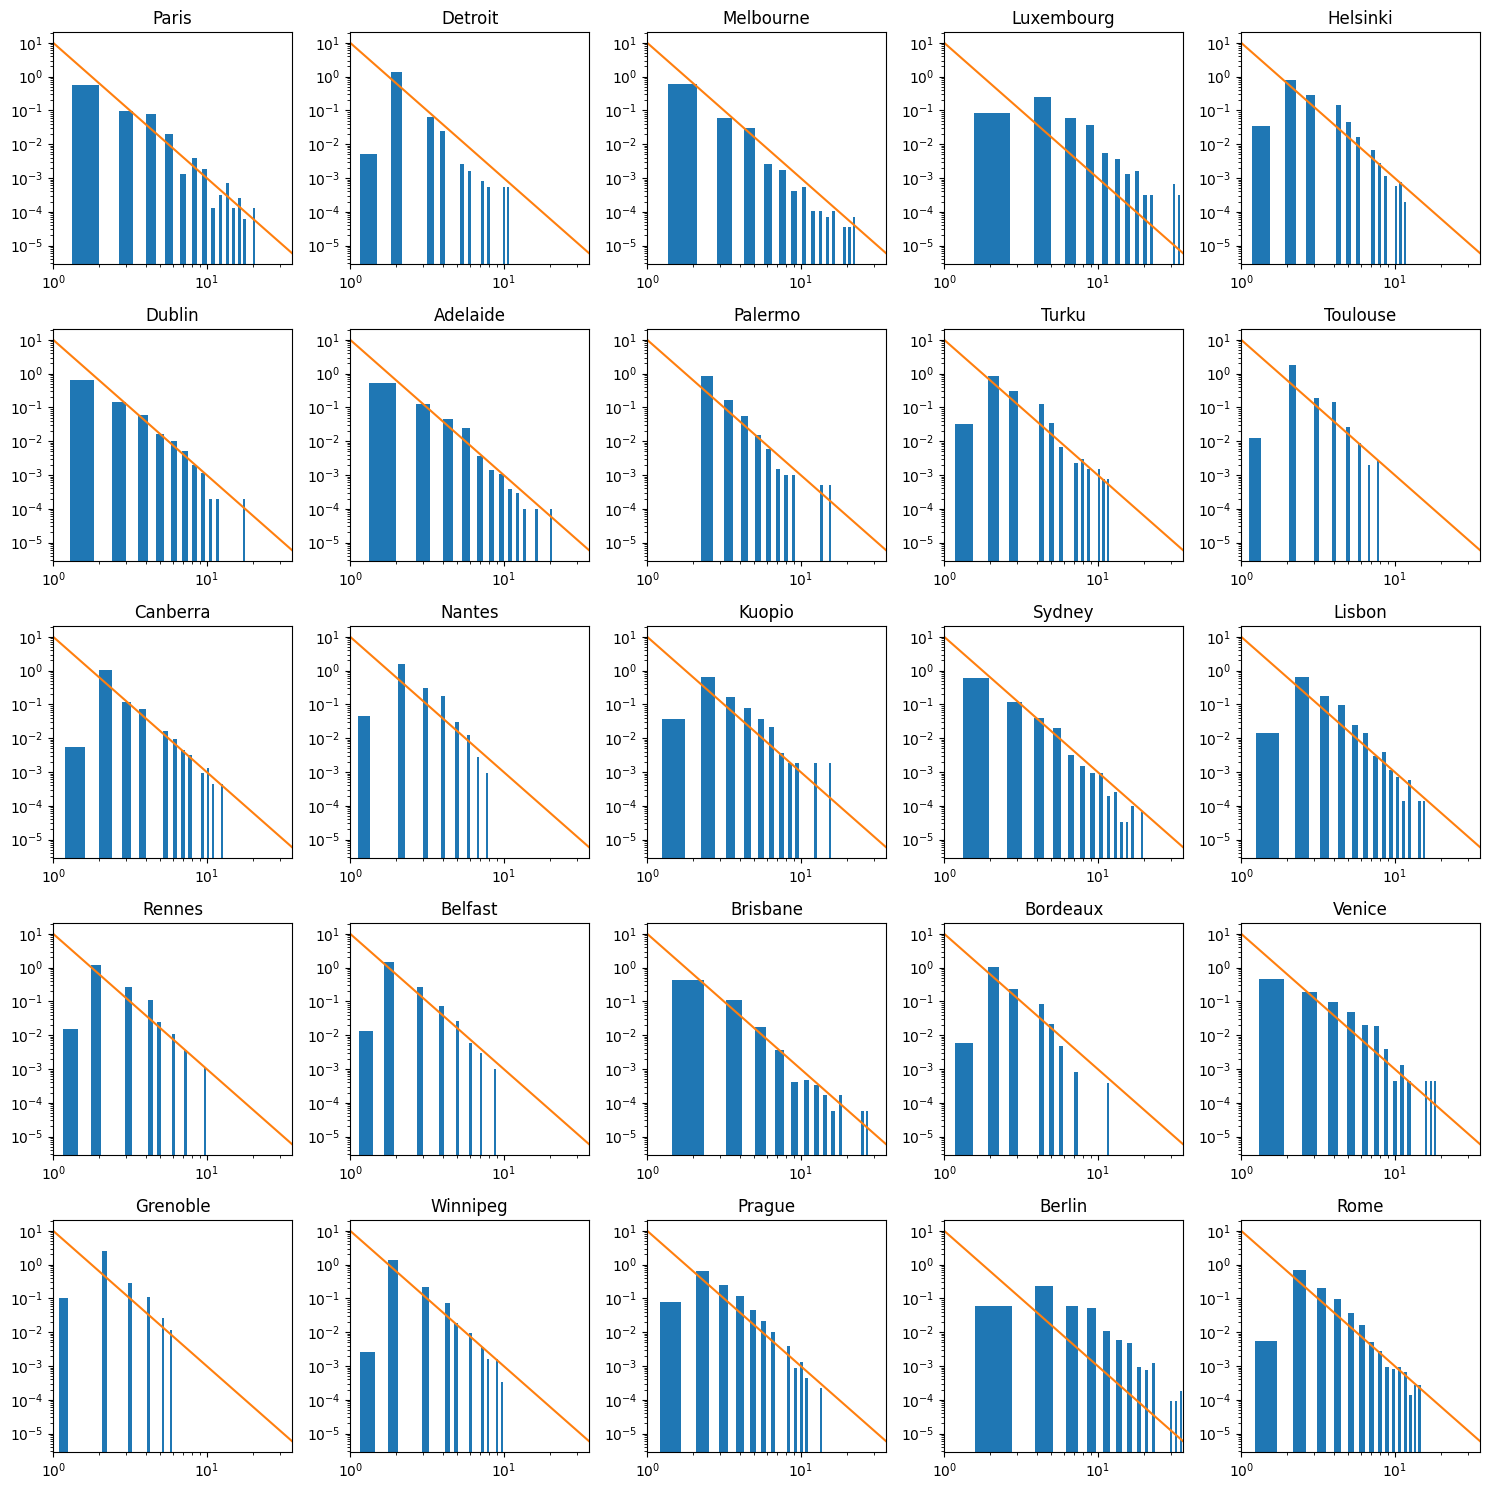

In [10]:
inspect_distributions(Gs_combined, cities, distribution='power-law', C=10, gamma=4)

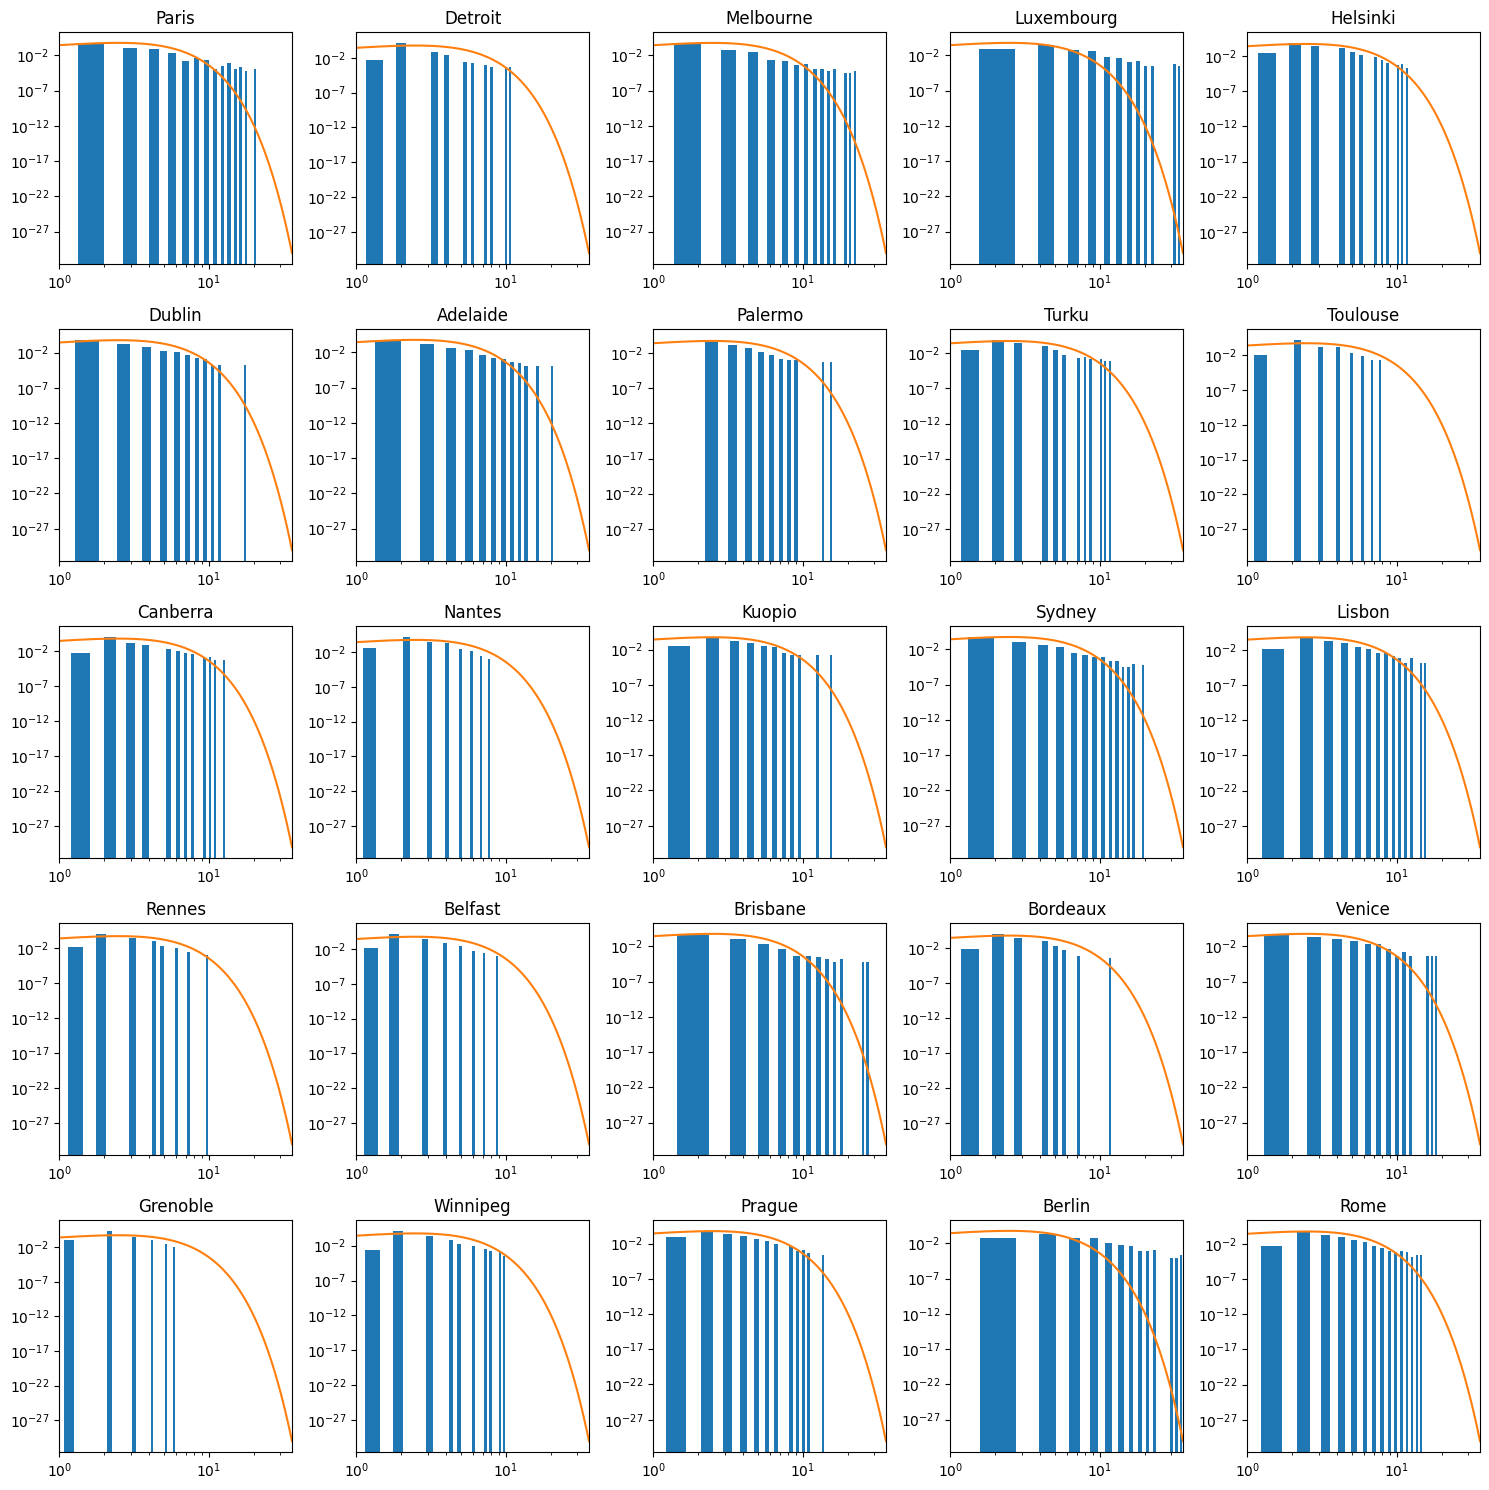

In [12]:
inspect_distributions(Gs_combined, cities, distribution='poisson', mu=2)

The previous examination was carried out focusing on various modes of transportation. We will now integrate walking into our research scope. It's important to note that the network illustrating the transportation modes is directed, whereas the network indicating walking paths is undirected. To merge these networks into a unified one, we need to convert the walking network into a directed format where nodes are mutually connected.

In [13]:
Gs_walk = [load_graph(city, "walk") for city in cities]

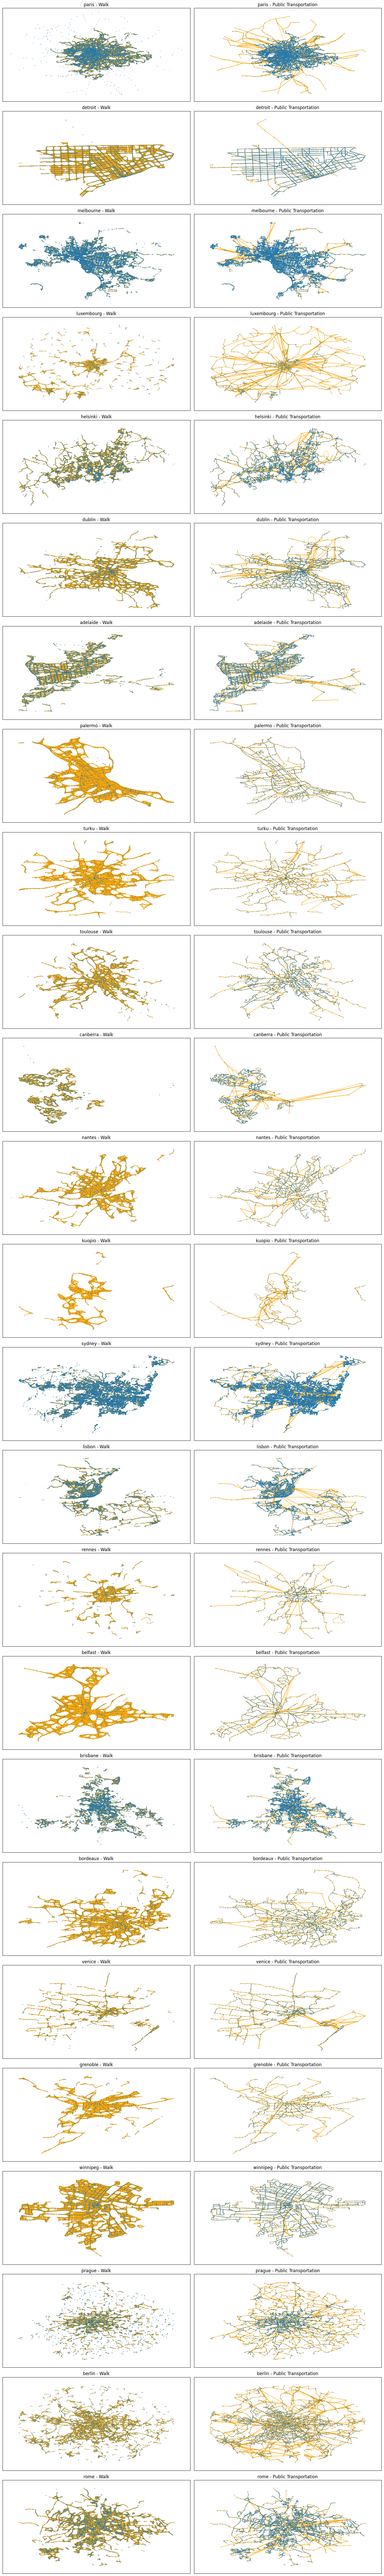

In [14]:
fig, axs = plt.subplots(25, 2, figsize=(15, 100))

for i in range(25):
    vis_graph(Gs_walk[i], axs[i, 0])
    axs[i, 0].set_title(f'{cities[i]} - Walk')

    vis_graph(Gs_combined[i], axs[i, 1])
    axs[i, 1].set_title(f'{cities[i]} - Public Transportation')

plt.tight_layout()
plt.show()

In [15]:
# Combine the two Muti-directed graphs
Gs = [nx.compose(G_combined, G_walk_und) for G_combined, G_walk_und in zip(Gs_combined, Gs_walk)]

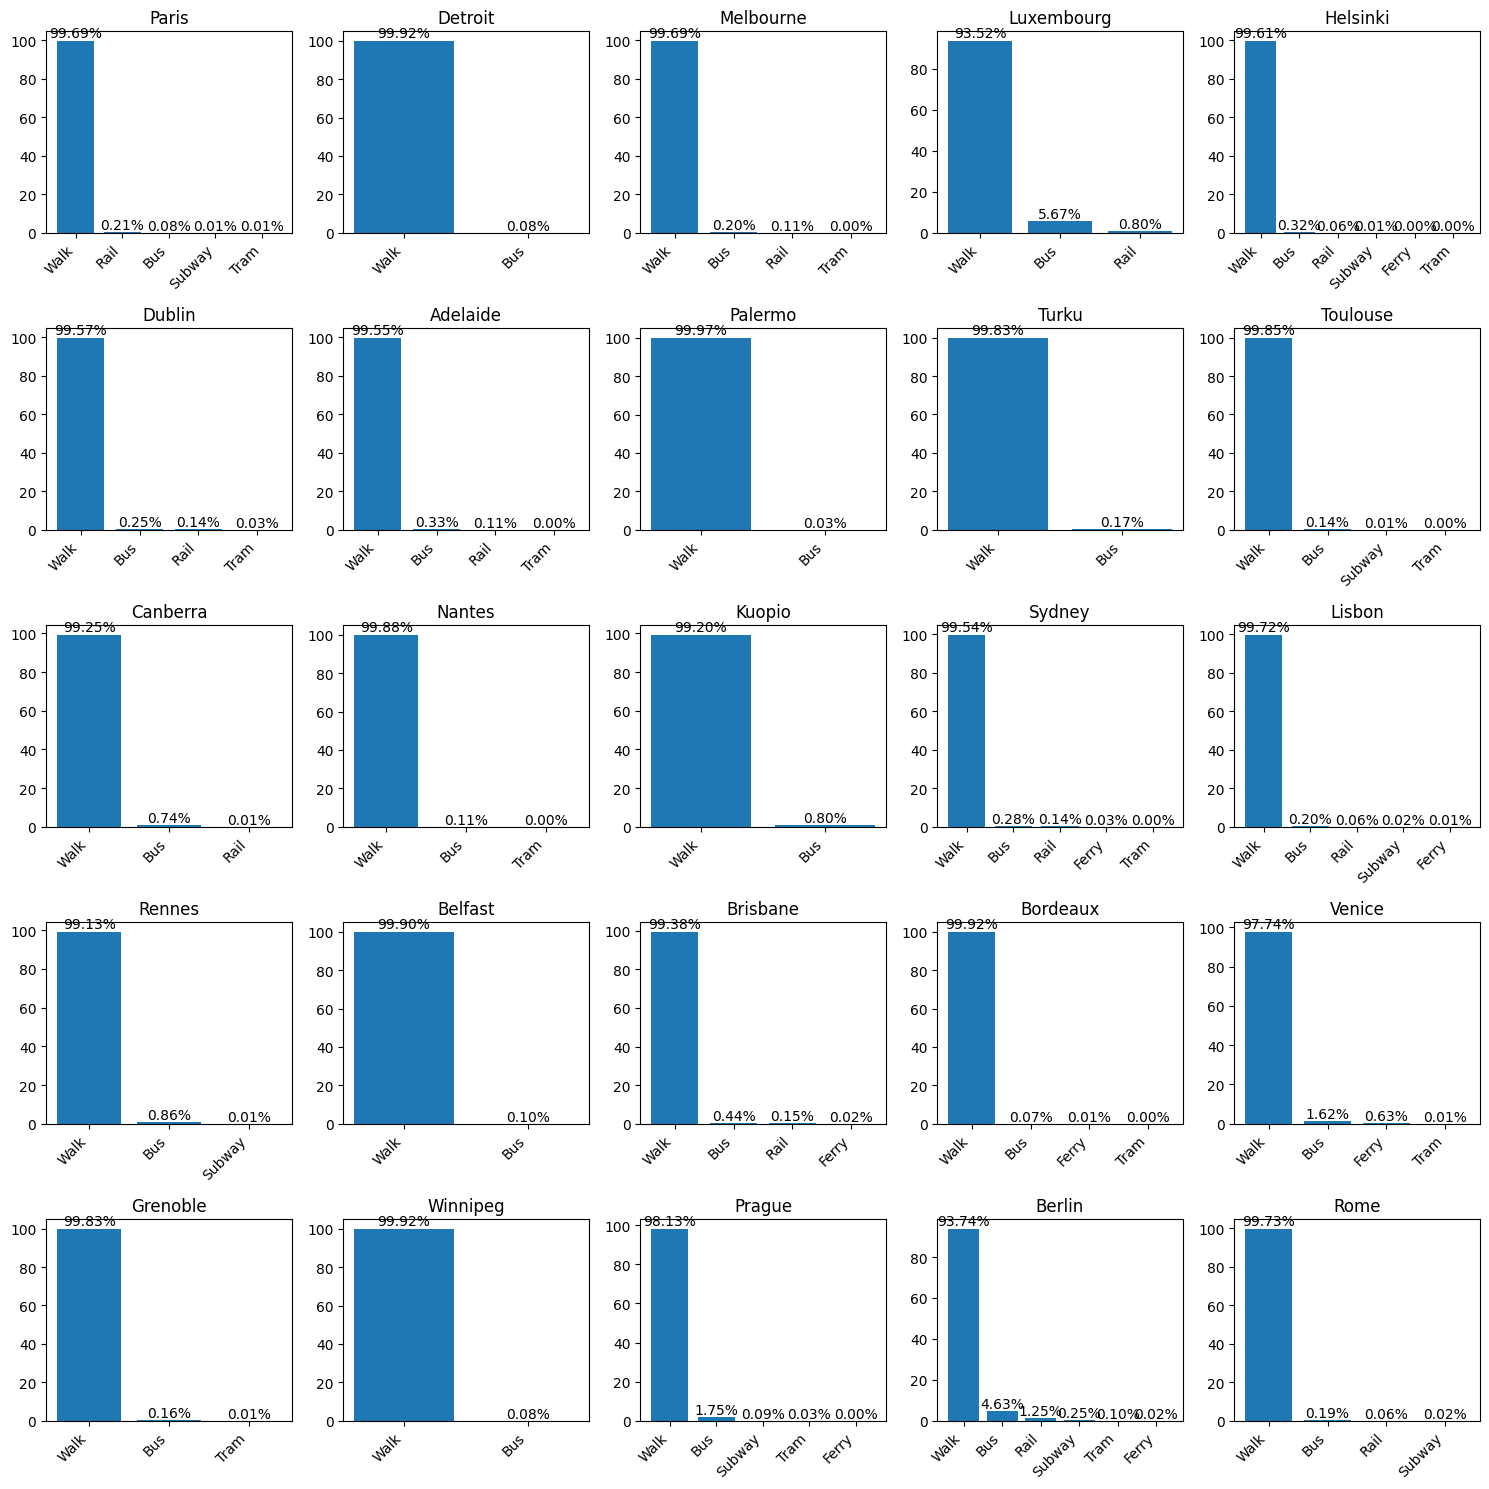

In [16]:
# Create a 5x5 subplot grid
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Plot route percentages for each city
for ax, city, graph in zip(axs.flatten(), cities, Gs):
    plot_route_percentages(city, graph, ax)

plt.tight_layout()
plt.show()

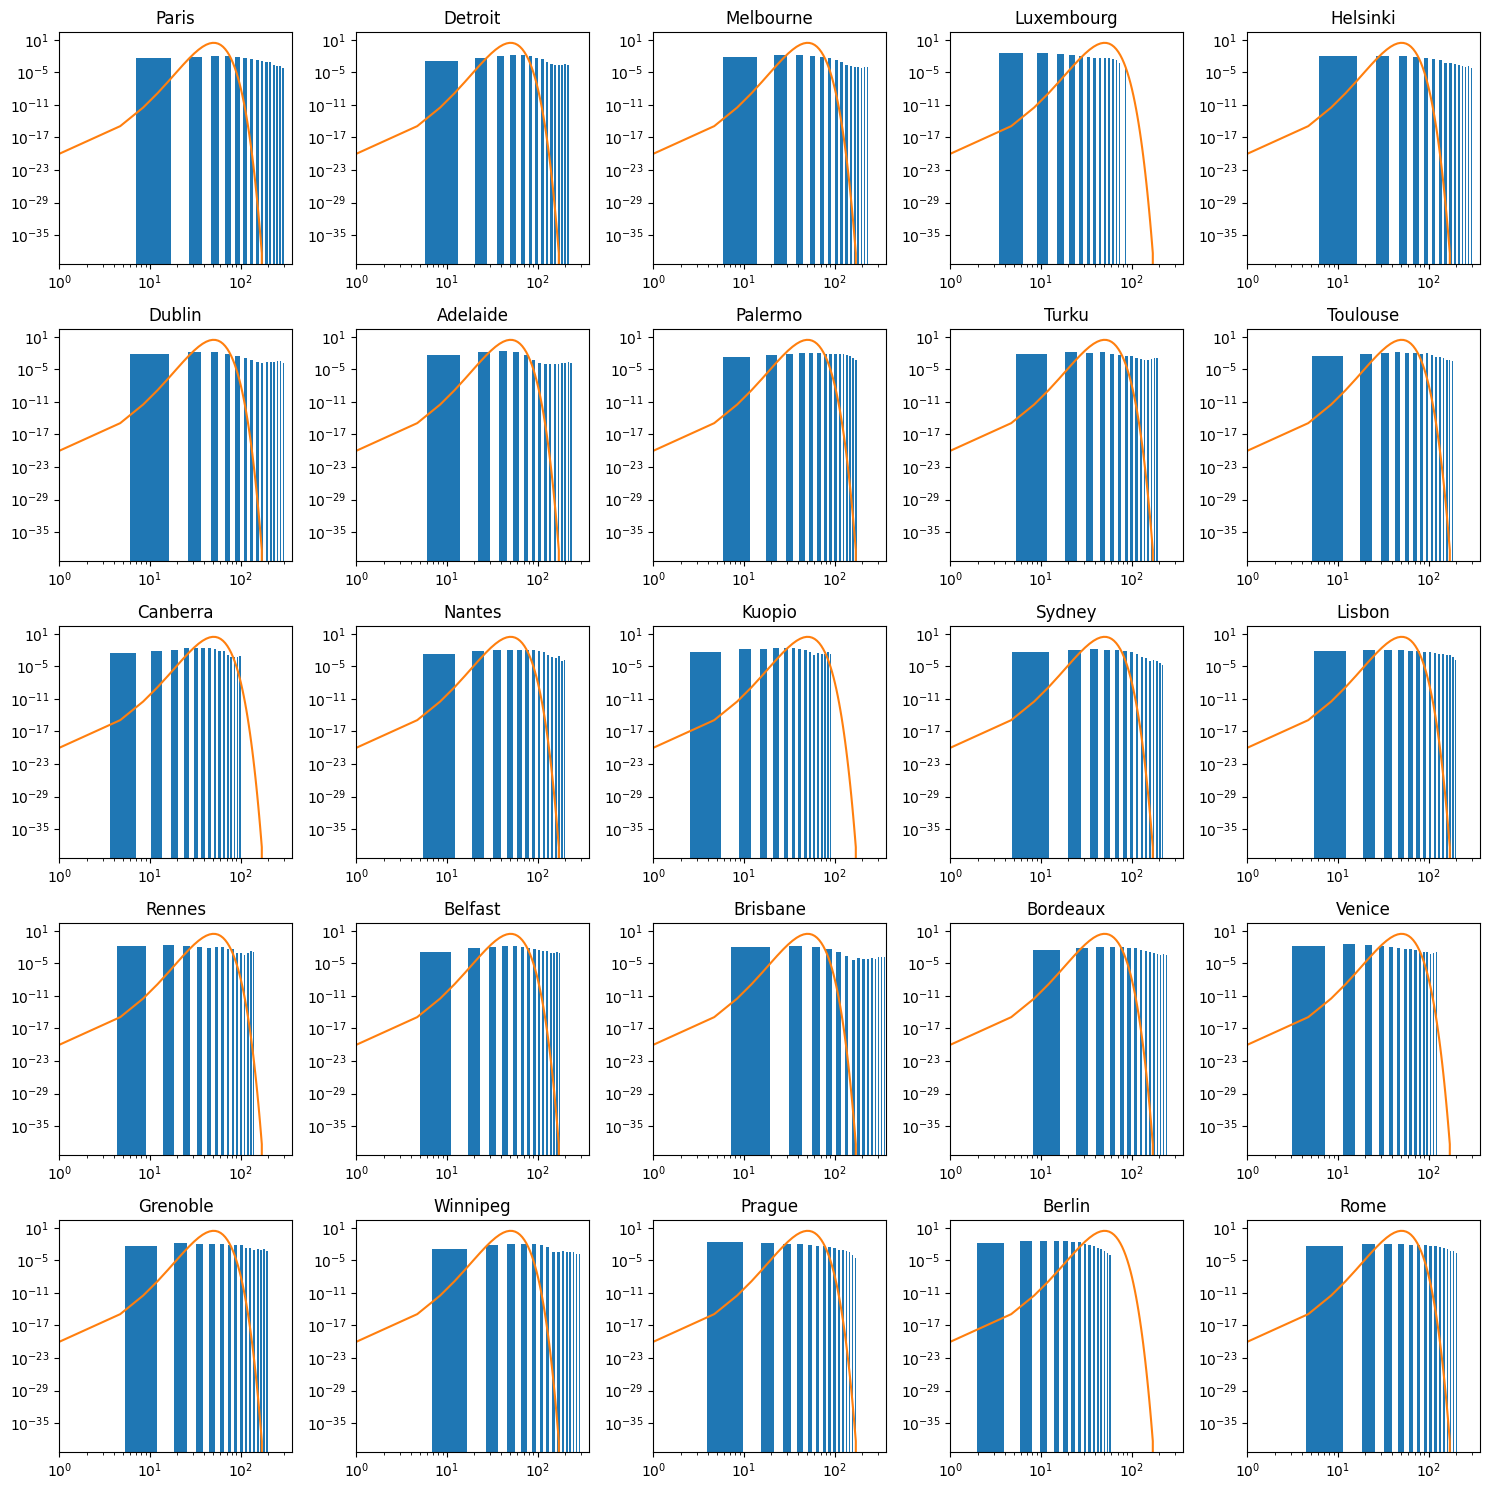

In [25]:
inspect_distributions(Gs, cities, distribution='poisson', mu=50)

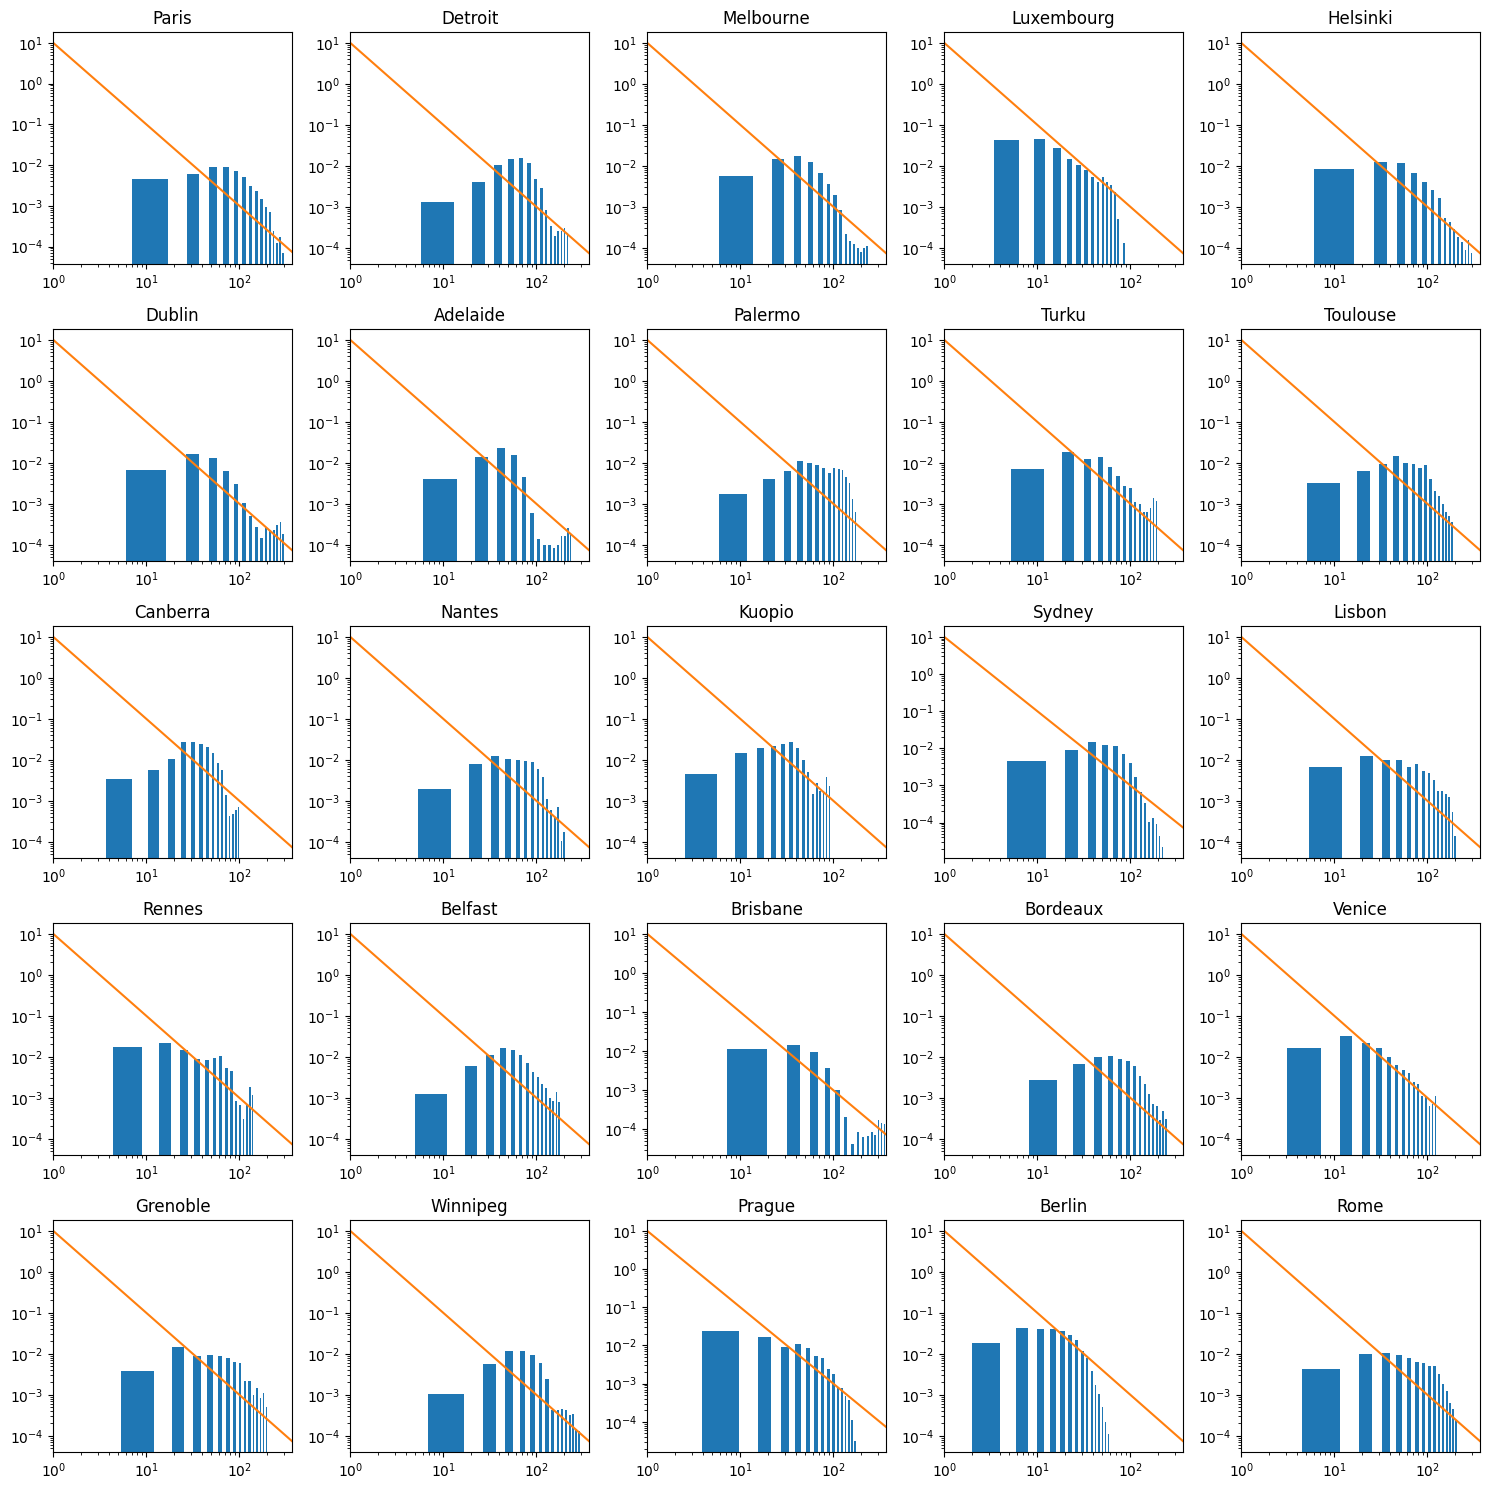

In [18]:
inspect_distributions(Gs, cities, distribution='power-law', C=10, gamma=2) # mutli-links

In [19]:
2 * Gs_walk[1].number_of_edges() / Gs_walk[1].number_of_nodes()

66.69012845328172

In [20]:
2 * Gs_combined[1].number_of_edges() / Gs_combined[1].number_of_nodes()

2.0932606017948268

In [21]:
2 * Gs[1].number_of_edges() / Gs[1].number_of_nodes()

66.74502903396093

In [28]:
def calculate_average_walking_distance(cities, path_prefix="../Data/all_cities"):
    avg_walking_distances = {}

    for idx, city in enumerate(cities):
        edges_path = os.path.join(path_prefix, city, "network_walk.csv")
        edges = pd.read_csv(edges_path, sep=";")
        avg_walking_distance = edges["d_walk"].mean()
        avg_walking_distances[city] = avg_walking_distance

    # Sort the dictionary in descending order of average walking distance
    avg_walking_distances = {k: v for k, v in sorted(avg_walking_distances.items(), key=lambda item: item[1], reverse=True)}

    for city, avg_walking_distance in avg_walking_distances.items():
        print(f"{city.capitalize()} - Average walking distance: {avg_walking_distance:.2f}")

    return avg_walking_distances


In [29]:
calculate_average_walking_distance(all_cities)

Berlin - Average walking distance: 662.60
Paris - Average walking distance: 652.24
Luxembourg - Average walking distance: 640.58
Rome - Average walking distance: 637.45
Palermo - Average walking distance: 636.14
Winnipeg - Average walking distance: 634.38
Dublin - Average walking distance: 632.19
Helsinki - Average walking distance: 632.19
Turku - Average walking distance: 630.71
Adelaide - Average walking distance: 629.61
Detroit - Average walking distance: 627.96
Lisbon - Average walking distance: 627.58
Bordeaux - Average walking distance: 625.97
Sydney - Average walking distance: 625.34
Brisbane - Average walking distance: 624.89
Melbourne - Average walking distance: 624.88
Belfast - Average walking distance: 624.58
Canberra - Average walking distance: 623.77
Nantes - Average walking distance: 623.65
Kuopio - Average walking distance: 622.77
Grenoble - Average walking distance: 621.02
Rennes - Average walking distance: 620.20
Toulouse - Average walking distance: 617.64
Prague - Ave

{'berlin': 662.5950896551724,
 'paris': 652.2419285236374,
 'luxembourg': 640.5839853504245,
 'rome': 637.4523590231148,
 'palermo': 636.1441570108958,
 'winnipeg': 634.3803244729058,
 'dublin': 632.1947587462608,
 'helsinki': 632.1859627011166,
 'turku': 630.7108204216408,
 'adelaide': 629.6068806695969,
 'detroit': 627.9581741424802,
 'lisbon': 627.5818176877649,
 'bordeaux': 625.9710311852726,
 'sydney': 625.3389729068219,
 'brisbane': 624.8902081414313,
 'melbourne': 624.8781069871318,
 'belfast': 624.5772127739341,
 'canberra': 623.7706584702684,
 'nantes': 623.6477683098216,
 'kuopio': 622.7712018140589,
 'grenoble': 621.0192372977255,
 'rennes': 620.1985087848811,
 'toulouse': 617.6389623942455,
 'prague': 612.9846398414435,
 'venice': 599.1484924053502}

## Sparsity

In [23]:
for city, graph in zip(cities, Gs):
    n_edges = graph.number_of_edges()
    n_vertices = graph.number_of_nodes()
    max_n_edges = n_vertices * (n_vertices - 1)  # Recall we have a directed graph
    print(city.capitalize(), ":")
    print("\tNum edges:", n_edges)
    print("\tMax num edges:", max_n_edges)
    print(f"\tPercentage of edges present: {n_edges / max_n_edges * 100 :.3f}%")
    print("---")

Paris :
	Num edges: 506763
	Max num edges: 151203912
	Percentage of edges present: 0.335%
---
Detroit :
	Num edges: 189656
	Max num edges: 32290806
	Percentage of edges present: 0.587%
---
Melbourne :
	Num edges: 471620
	Max num edges: 379957556
	Percentage of edges present: 0.124%
---
Luxembourg :
	Num edges: 12846
	Max num edges: 1867322
	Percentage of edges present: 0.688%
---
Helsinki :
	Num edges: 203920
	Max num edges: 50076852
	Percentage of edges present: 0.407%
---
Dublin :
	Num edges: 123553
	Max num edges: 21339780
	Percentage of edges present: 0.579%
---
Adelaide :
	Num edges: 171859
	Max num edges: 58713906
	Percentage of edges present: 0.293%
---
Palermo :
	Num edges: 86849
	Max num edges: 4732800
	Percentage of edges present: 1.835%
---
Turku :
	Num edges: 47326
	Max num edges: 3420650
	Percentage of edges present: 1.384%
---
Toulouse :
	Num edges: 161234
	Max num edges: 24685992
	Percentage of edges present: 0.653%
---
Canberra :
	Num edges: 51135
	Max num edges: 765352

In [24]:
for city, graph in zip(cities, Gs_combined):
    n_edges = graph.number_of_edges()
    n_vertices = graph.number_of_nodes()
    max_n_edges = n_vertices * (n_vertices - 1)  # Recall we have a directed graph
    print(city.capitalize(), ":")
    print("\tNum edges:", n_edges)
    print("\tMax num edges:", max_n_edges)
    print(f"\tPercentage of edges present: {n_edges / max_n_edges * 100 :.3f}%")
    print("---")

Paris :
	Num edges: 14781
	Max num edges: 142790550
	Percentage of edges present: 0.010%
---
Detroit :
	Num edges: 5948
	Max num edges: 32290806
	Percentage of edges present: 0.018%
---
Melbourne :
	Num edges: 21737
	Max num edges: 379957556
	Percentage of edges present: 0.006%
---
Luxembourg :
	Num edges: 3234
	Max num edges: 1867322
	Percentage of edges present: 0.173%
---
Helsinki :
	Num edges: 9072
	Max num edges: 48797210
	Percentage of edges present: 0.019%
---
Dublin :
	Num edges: 5567
	Max num edges: 20889470
	Percentage of edges present: 0.027%
---
Adelaide :
	Num edges: 9257
	Max num edges: 56964756
	Percentage of edges present: 0.016%
---
Palermo :
	Num edges: 2561
	Max num edges: 4732800
	Percentage of edges present: 0.054%
---
Turku :
	Num edges: 2341
	Max num edges: 3420650
	Percentage of edges present: 0.068%
---
Toulouse :
	Num edges: 3793
	Max num edges: 11078912
	Percentage of edges present: 0.034%
---
Canberra :
	Num edges: 3218
	Max num edges: 7636932
	Percentage of

In [ ]:
all_statistics = {}
with tqdm(total=len(all_cities), desc="Computing graph statistics...") as pbar:
    for city, graph in zip(all_cities, Gs_combined):
        g_stats = compute_graph_main_statistics(graph)
        all_statistics[city] = g_stats
        pbar.update(1)
    

Save statistics to disk as they take long to generate:

In [ ]:
import pickle
for city, stats in all_statistics.items():
    fname = os.path.join('statistics', f"{city}.pkl")
    with open(fname, "wb") as f:
        pickle.dump(stats, f)

print("Saved statistics to disk")

In [ ]:
G = Gs_combined[0]
G_stats = compute_graph_main_statistics(G)

Note: in/out average degree is the same because in and out degree is always the same, since all buses arriving at one stop must leave it.

### Probably better approximation by random network than scale free
* See notion doc for explanation

TODOs to confirm that we have scale-free/heavy tailed networks

TODO: once we have the statistics, compute ln(N) / ln(k) and compare with average degree -> In random networks, it should match (see lecture 3, slide 40), but probably not the case for us as we saw fat tails in degree distribution.

In course we saw for undirected graph. Maybe ask Andrej what to do about it.

Check average distannce against scale free as well (lec 4: should be ln(N) but here it's not matchint; check other graphs)

Check clustering coefficient also. Should be Ln(N) ** 2 / N

In [ ]:
G_stats

In [ ]:
np.log(G_stats['n']) / np.log(1.2), np.log(G_stats['n']) / np.log(3), np.log(G_stats['n']), np.log(G_stats['n']) / np.log(np.log(G_stats['n']))


In [ ]:
n = G_stats['n']
np.log(n)

In [ ]:
1.225020920502092 * 2 / 11950